In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import json
import os

In [2]:
res_dir = '/home/lmoroni/__workdir/augmenting_nlms_meco/output/'
gaze_finetuning_dirs = [os.path.join(res_dir, dir_name) for dir_name in os.listdir(res_dir) if dir_name.startswith('gaze_finetuning')]

In [3]:
metric = 'mae'

In [4]:
def get_model_config(src_dir):
    model_config = dict()
    dir_name = src_dir.split('/')[-1]
    model_config['language_mode'] = 'cross_lingual' if 'xlm' in dir_name else 'mono_lingual'
    splitted_dir_name = dir_name.split('_')
    model_config ['language'] = splitted_dir_name[2]
    model_config['user'] = splitted_dir_name[3]
    model_config['pretrained'] = True if splitted_dir_name[4] == 'p' else False
    return model_config

In [5]:
def load_finetuning_results(src_dir, metric):
    res_path = os.path.join(src_dir, 'finetuning_results.json')
    res_dict = dict()
    with open(res_path, 'r') as res_file:
        res_json = json.load(res_file)
    for key, value in res_json['losses_ts'].items():
        if key.startswith(metric):
            res_dict[key[len(f'{metric}_'):]] = float(value)
    return res_dict

In [6]:
def init_res_dict(model_config, model_res):
    res_dict = dict()
    for key in list(model_config.keys())+list(model_res.keys()):
        res_dict[key] = []
    return res_dict

In [7]:
res_dict = None
value_columns = None
for src_dir in gaze_finetuning_dirs:
    model_config = get_model_config(src_dir)
    model_res = load_finetuning_results(src_dir, metric)
    if res_dict is None:
        res_dict = init_res_dict(model_config, model_res)
        value_columns = list(model_res.keys())
    for model_dict in [model_config, model_res]:
        for key, value in model_dict.items():
            res_dict[key].append(value)

In [8]:
df = pd.DataFrame.from_dict(res_dict)

In [9]:
def get_model_str(language, language_mode, pretrained):
    language_mode_str = 'cl' if language_mode == 'cross_lingual' else 'ml'
    pretrained_str = 'pt' if pretrained else 'rand'
    return f'{language}_{language_mode_str}_{pretrained_str}'

In [10]:
average_df_list = []
for language in df['language'].unique():
    for language_mode in df['language_mode'].unique():
        for pretrained in df['pretrained'].unique():
            model_str = get_model_str(language, language_mode, pretrained)
            model_df = df[(df['language']==language) & (df['language_mode'] == language_mode) & (df['pretrained'] == pretrained)]
            average_df = model_df[value_columns].mean().to_frame().T
            average_df['model'] = model_str
            average_df_list.append(average_df)

In [11]:
all_df = pd.concat(average_df_list, ignore_index=True)
all_df = all_df.set_index('model')
all_df['feat_avg'] = all_df.mean(axis=1)
all_df = all_df.map(lambda x: 100 -x)

In [12]:
all_df

,skip,firstfix_dur,firstrun_dur,dur,firstrun_nfix,nfix,refix,reread,feat_avg
model,,,,,,,,,
en_cl_rand,86.322286,94.158349,96.270079,96.493899,94.462938,95.604226,91.900772,88.834568,93.005889
en_cl_pt,86.289916,94.418398,96.518859,96.773912,94.819387,95.941779,91.872477,89.065330,93.212507
en_ml_rand,83.583782,93.069325,95.531064,95.785039,93.404920,94.731328,90.320731,86.609246,91.629429
en_ml_pt,85.260340,93.703221,96.042864,96.304303,94.165670,95.387218,90.782430,87.564298,92.401293
it_cl_rand,88.733221,94.218062,96.408331,96.763373,95.702381,96.452833,90.842257,86.543885,93.208043
it_cl_pt,89.337087,94.619526,96.769370,97.070514,96.118362,96.790583,91.004025,87.063776,93.596655
it_ml_rand,87.822043,93.802666,96.113489,96.473796,95.373573,96.143441,90.117054,85.518718,92.670598
it_ml_pt,88.073366,93.423909,95.991265,96.392427,95.213133,96.024280,90.384996,85.650759,92.644267


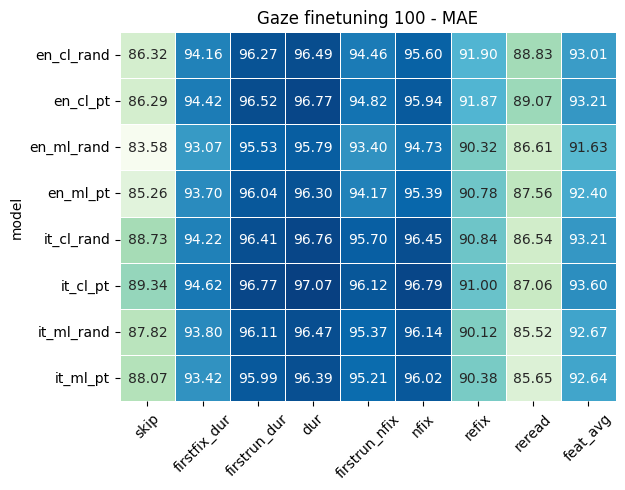

In [13]:
sns.heatmap(data=all_df, annot=True, fmt=".2f", cmap='GnBu', cbar=False, linewidth=.5).set_title(f'Gaze finetuning 100 - {metric.upper()}');
plt.xticks(rotation=45) ;

# Not averaged

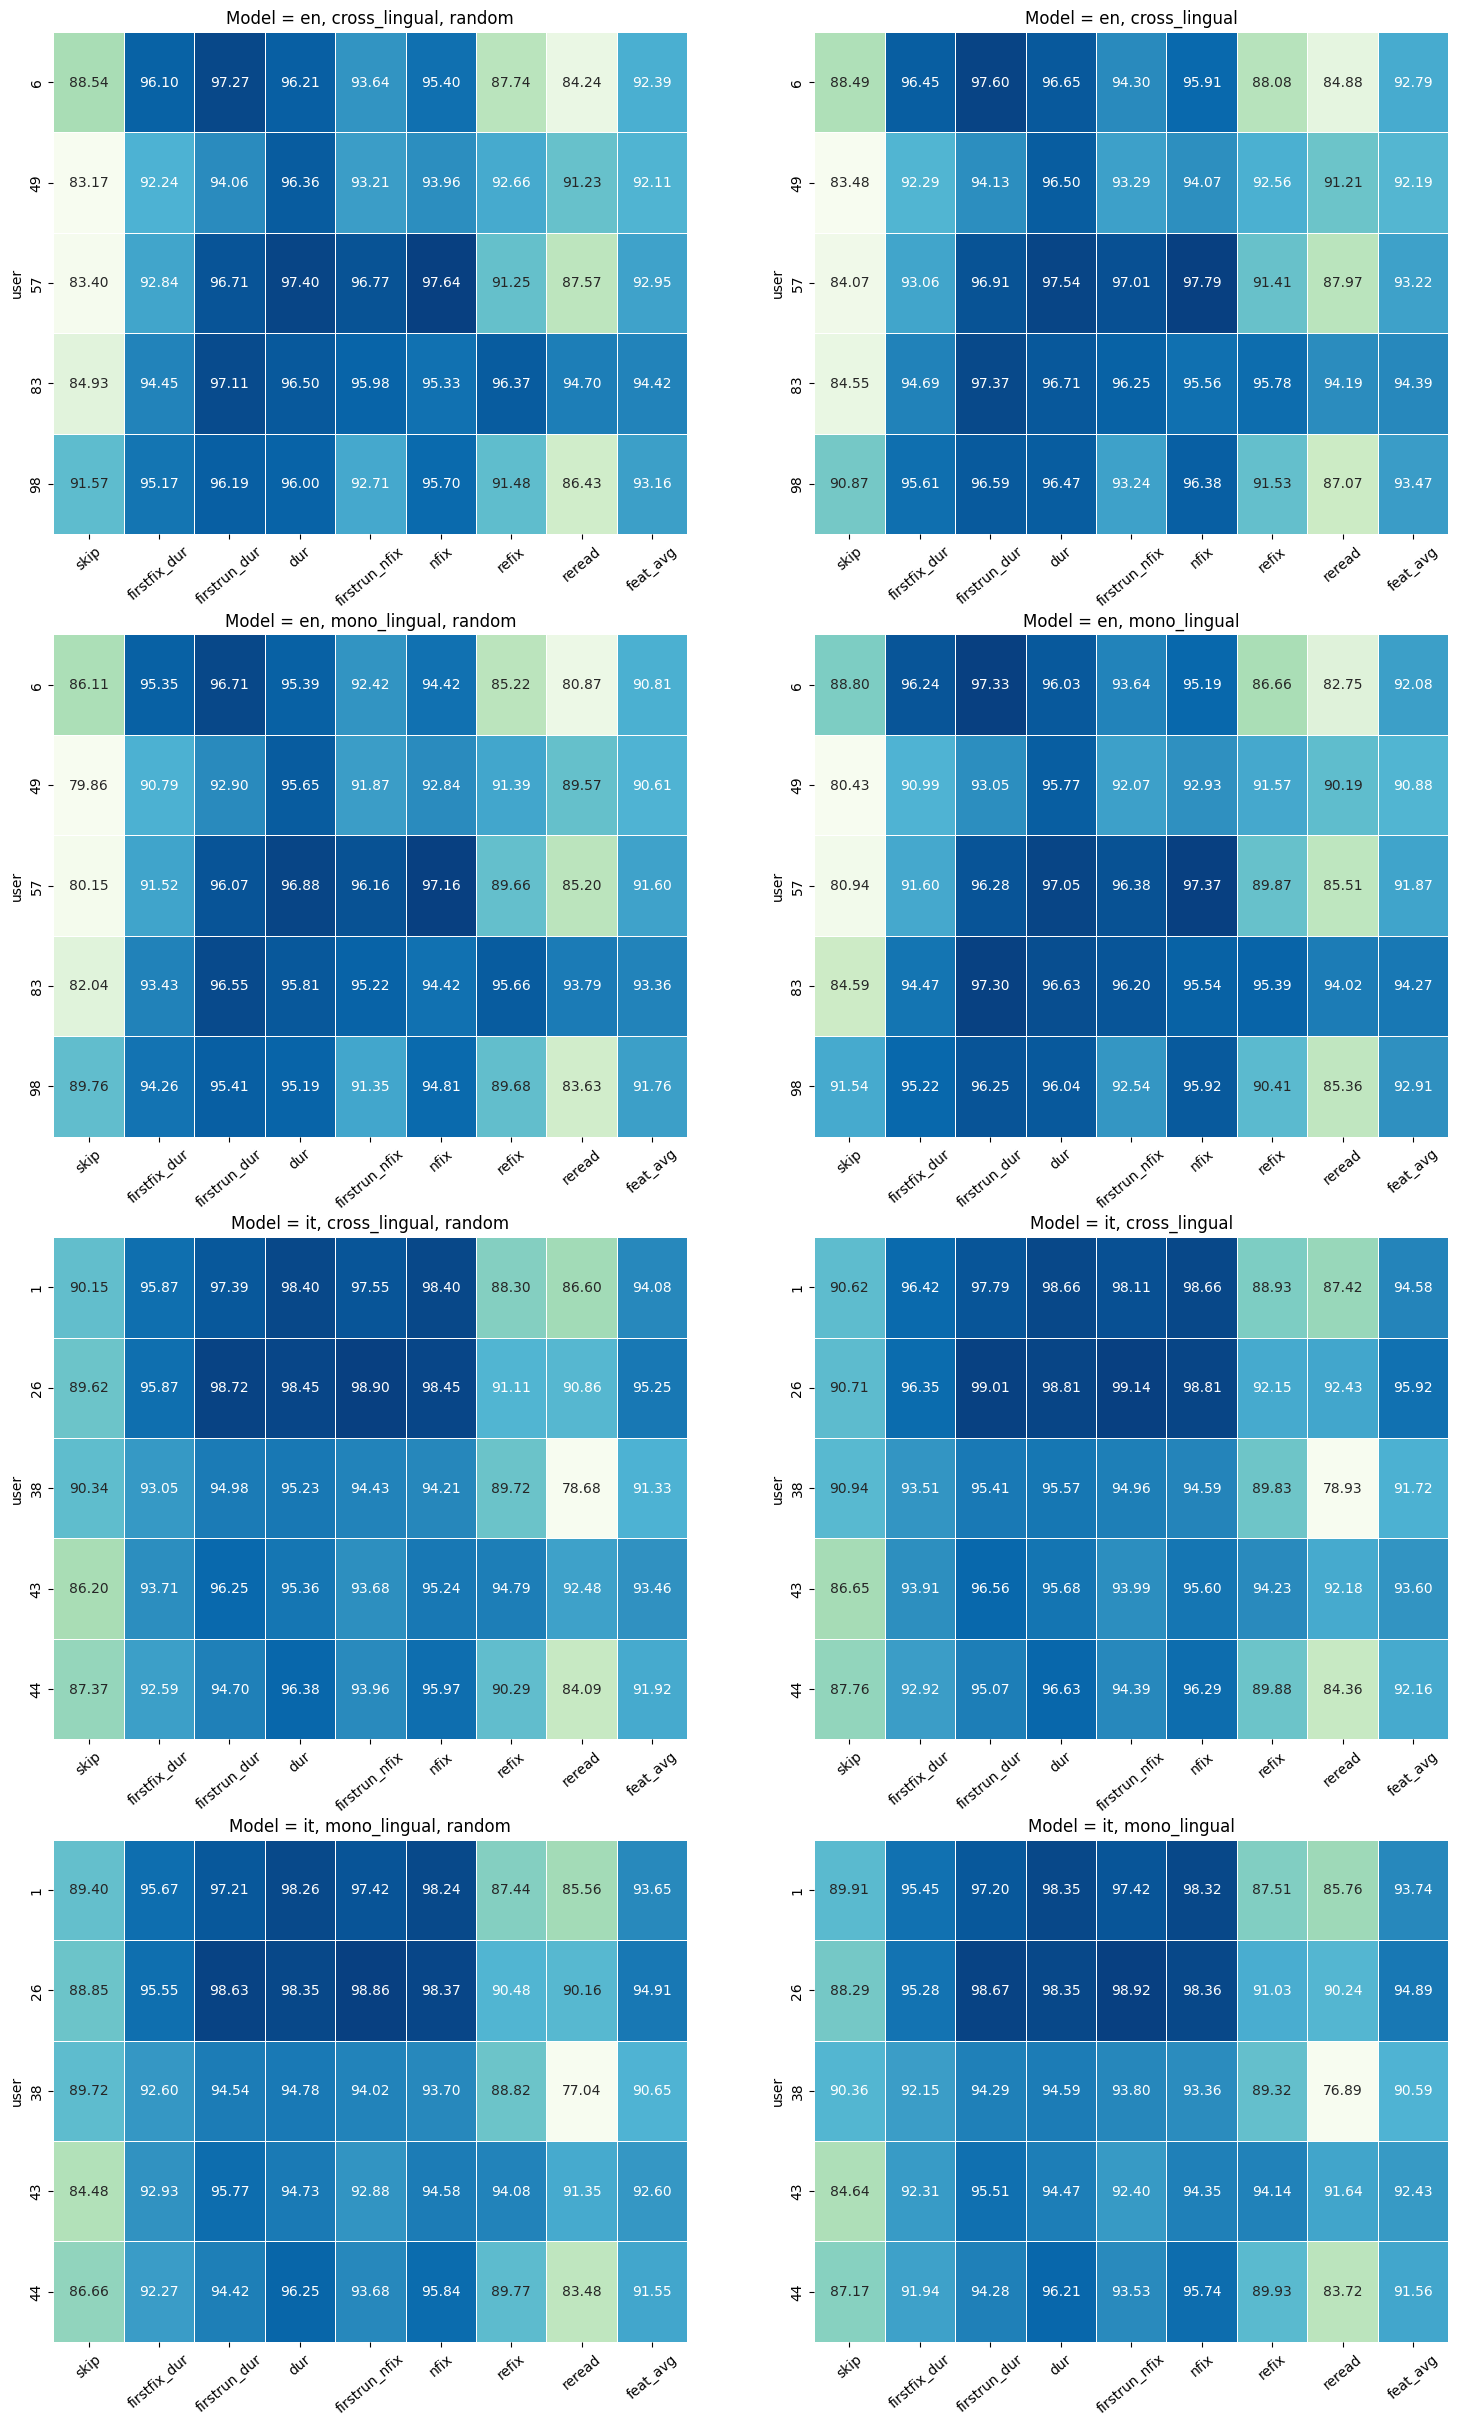

In [54]:
fig, axes = plt.subplots(4, 2, figsize=(18, 30));
axes = axes.flatten();
ax_idx = 0
average_df_list = []
for language in df['language'].unique():
    for language_mode in df['language_mode'].unique():
        for pretrained in df['pretrained'].unique():
            pretrained_str = '' if pretrained else ', random'
            model_str = get_model_str(language, language_mode, pretrained)
            model_df = df[(df['language']==language) & (df['language_mode'] == language_mode) & (df['pretrained'] == pretrained)]
            model_df = model_df[['user']+value_columns]
            model_df['user'] = model_df['user'].map(lambda x: int(x))
            model_df = model_df.set_index('user')
            model_df['feat_avg'] = model_df.mean(axis=1)
            model_df = model_df.sort_index()
            # model_df.loc['mean'] = model_df.mean()
            # model_df.loc['max_diff'] = model_df.max() - model_df.min()
            # model_df.loc['dev_std'] = model_df.std()
            model_df = model_df.map(lambda x: 100 - x)
            sns.heatmap(ax=axes[ax_idx], data=model_df, annot=True, fmt=".2f", cmap='GnBu', cbar=False, linewidth=.5).set_title(f'Model = {language}, {language_mode}{pretrained_str}');
            for tick in axes[ax_idx].get_xticklabels():
                tick.set_rotation(40)
            
            ax_idx += 1
            # plt.show()
            # plt.clf()
# fig.savefig('/home/luca/Workspace/augmenting_nlms_meco/output/plots/gaze_finetuning_all.png')